In [ ]:
# 1. Get essential libraries
from vnstock import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

Observations:  1630


<Axes: xlabel='Time'>

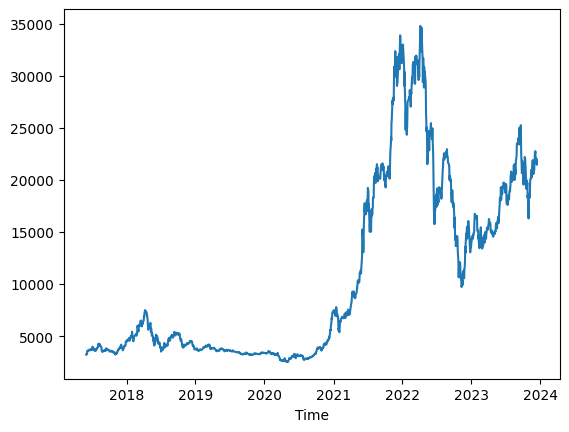

In [ ]:
#2. Fetch data and visualize
# VND
VND = stock_historical_data(symbol = "VND", start_date="2017-06-01", end_date="2023-12-15", resolution="1D", type = "stock", beautify=True, decor=True, source = "DNSE")
from matplotlib import pyplot
print("Observations: ",len(VND['Close']))
VND
VND["Close"].plot()

In [ ]:
# Preprocessing
df = pd.DataFrame(VND['Close'])
df = df.dropna()
df = df.reset_index(drop=True)
df

,Close
0,3230
1,3280
2,3280
3,3320
4,3590
...,...
1625,21950
1626,22050
1627,21600
1628,21450


In [ ]:
# Check stationary
from statsmodels.tsa.stattools import adfuller
adf1 = adfuller(df['Close'], regression ='c', maxlag=30)
print("ADF stat: %f" % adf1[0])
print("p-value: %f" % adf1[1])
#Not stationary

ADF stat: -1.199031
p-value: 0.674012


In [ ]:
adf2 = adfuller(df['Close'].diff().dropna(), regression ='c', maxlag=30)
print("ADF stat: %f" % adf2[0])
print("p-value: %f" % adf2[1])
#Stationary

ADF stat: -5.780095
p-value: 0.000001


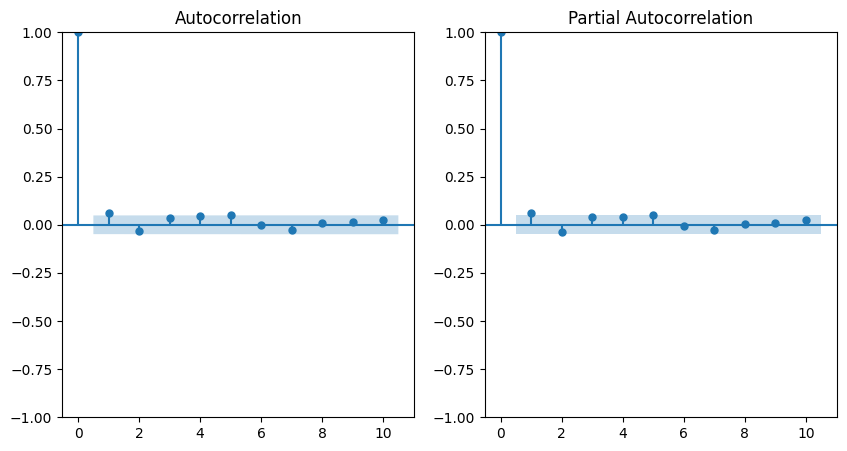

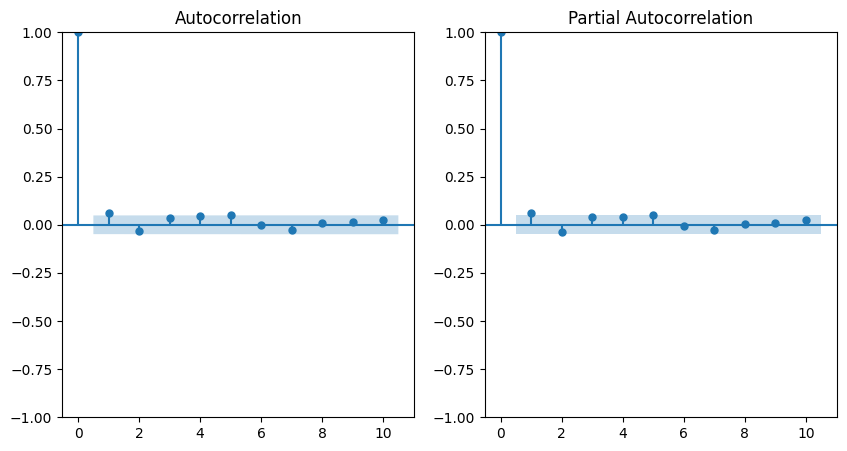

In [ ]:
# Difference the data and plot the acf
fig, ax = plt.subplots(1,2,figsize=(10,5))
#ACF
sm.graphics.tsa.plot_acf(np.diff(df['Close']),lags=10, ax=ax[0])
# PACF
sm.graphics.tsa.plot_pacf(np.diff(df['Close']),lags=10, ax=ax[1])

In [ ]:
# Test with ratio 6:4
train_size64 = int(0.6 * len(df))
test_size64 = int(0.4 * len(df))

train_data64 = df[:train_size64]
test_data64 = df[train_size64:]

In [ ]:
# Test with ratio 6:4
x_train64 = np.array(train_data64.index).reshape(-1, 1)
y_train64 = np.array(train_data64['Close'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

model64 = auto_arima(y_train64, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model_fit64 = model64.fit(y_train64)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=12253.135, Time=0.29 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=12851.895, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=12594.433, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=12252.885, Time=0.06 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=12251.555, Time=0.14 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=12252.832, Time=0.28 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=12256.699, Time=0.29 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=12251.732, Time=0.19 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=12488.817, Time=0.04 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec

Best model:  ARIMA(1,2,1)(0,0,0)[0]          
Total fit time: 1.501 seconds


In [ ]:
# 6:4 RATIO
x_test64 = np.array(test_data64.index).reshape(-1, 1)
y_test64 = np.array(test_data64['Close'])
y_pred64 = model64.predict(n_periods=len(y_test64))

In [ ]:
# 6:4 RATIO
last_index64 =  df.index[-1]
last_data64 =pd.RangeIndex(start=last_index64, stop=last_index64 + 60, step=1)

#create an array of 60 integers starting from last index
x_next_60_days64 = np.array(range(last_index64 + 1, last_index64 + 61)).reshape(-1, 1)

#predict the price for the next 60 days.
y_next_60_days64 = model64.predict(len(x_next_60_days64))

#print the prices for the next 60 days.
print('Predicted prices for the next 60 days: ')
print(y_next_60_days64)

Predicted prices for the next 60 days: 
[10104.59848497 10145.50873351 10187.38793725 10229.3246991
 10271.26488003 10313.20526406 10355.14566015 10397.08605697
 10439.02645382 10480.96685068 10522.90724753 10564.84764439
 10606.78804125 10648.7284381  10690.66883496 10732.60923182
 10774.54962867 10816.49002553 10858.43042238 10900.37081924
 10942.3112161  10984.25161295 11026.19200981 11068.13240667
 11110.07280352 11152.01320038 11193.95359724 11235.89399409
 11277.83439095 11319.77478781 11361.71518466 11403.65558152
 11445.59597838 11487.53637523 11529.47677209 11571.41716895
 11613.3575658  11655.29796266 11697.23835952 11739.17875637
 11781.11915323 11823.05955009 11864.99994694 11906.9403438
 11948.88074066 11990.82113751 12032.76153437 12074.70193122
 12116.64232808 12158.58272494 12200.52312179 12242.46351865
 12284.40391551 12326.34431236 12368.28470922 12410.22510608
 12452.16550293 12494.10589979 12536.04629665 12577.9866935 ]


In [ ]:
# 6:4 RATIO
#RMSE
test_rmse = np.sqrt(np.mean((y_pred64 - y_test64)**2))
print('Testing RMSE:', test_rmse)

#MAPE
test_mape = np.mean(np.abs((y_test64 - y_pred64) / y_test64)) * 100
print('Testing MAPE:', test_mape)

#MAE
test_mae = np.mean(np.abs(y_pred64 - y_test64))
print('Testing MAE:', test_mae)

def MSLE (pred, actual):
    return np.mean((np.log(1+actual)-np.log(1+pred))*(np.log(1+actual)-np.log(1+pred)))
print("Testing MSLR: ", MSLE(y_pred64, y_test64))

Testing RMSE: 11445.630766710707
Testing MAPE: 55.586157657158275
Testing MAE: 10396.539910457252
Testing MSLR:  0.2658939194276259


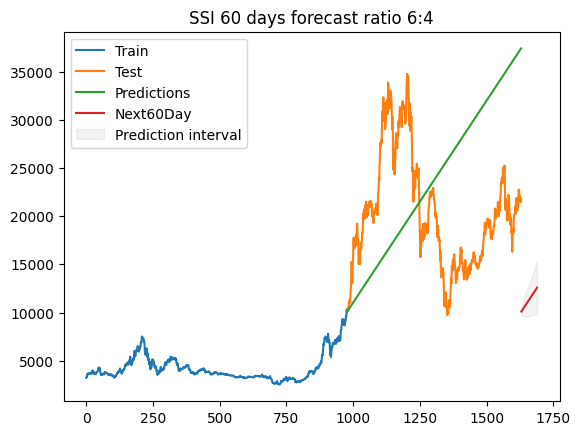

In [ ]:
# 6:4 RATIO
# Forecast
n_periods = 60
fc, confint = model_fit64.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(df['Close']), len(df['Close'])+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(train_data64.index, train_data64['Close'])
plt.plot(test_data64.index, test_data64['Close'])
plt.plot(test_data64.index, y_pred64)

plt.plot(fc_series)
plt.fill_between(lower_series.index,
                 lower_series,
                 upper_series,
                 color='k', alpha=.05)
plt.legend(['Train', 'Test', 'Predictions','Next60Day', 'Prediction interval'])

plt.title("SSI 60 days forecast ratio 6:4")
plt.show()
#The ratio and the model is not a good choice for this case

In [ ]:
#Forecast with ARIMA(2, 1, 2)
model64 = sm.tsa.arima.ARIMA(
    train_data64,
    order = (2,1,2)
)
model_fit64 = model64.fit()
model_fit64.summary()

C:\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  831
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -5751.392
Date:                Sat, 23 Dec 2023   AIC                          11512.784
Time:                        21:19:02   BIC                          11536.391
Sample:                             0   HQIC                         11521.837
                                - 831                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1080      0.008    -13.596      0.000      -0.124      -0.092
ar.L2         -0.9834      0.010    -94.302      0.000      -1.004      -0.963
ma.L1          0.1426      0.008     18.542      0.000       0.128       0.158
ma.L2          0.9973      0.018     55.537      0.000       0.962       1.032
sigma2      6.175e+04   1283.996     48.094      0.000    5.92e+04    6.43e+04
===================================================================================
Ljung-Box (L1) (Q):                   1.09   Jarque-Bera (JB):              8145.46
Prob(Q):                              0.30   Prob(JB):                         0.00
Heteroskedasticity (H):              16.09   Skew:                             0.49
Prob(H) (two-sided):                  0.00   Kurtosis:                        18.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# 5. Testing process
# 8:2 RATIO
x_test64 = np.array(test_data64.index).reshape(-1, 1)
y_test64 = np.array(test_data64['Close'])
y_pred64 = model_fit64.predict(start = train_size64, end = train_size64+test_size64)
y_pred64

831     19627.880941
832     19830.959001
833     19860.287834
834     19657.410541
835     19650.472358
            ...     
1381    19750.382517
1382    19750.564782
1383    19748.497560
1384    19748.541512
1385    19750.569711
Name: predicted_mean, Length: 555, dtype: float64

In [ ]:
# 6. 60 days prediction
# 8:2 RATIO
last_index64 =  df.index[-1]
last_data64 =pd.RangeIndex(start=last_index64, stop=last_index64 + 60, step=1)

#create an array of 60 integers starting from last index
x_next_60_days64 = np.array(range(last_index64 + 1, last_index64 + 61)).reshape(-1, 1)

#predict the price for the next 60 days.
y_next_60_days64 = model_fit64.predict(start = len(df)+1, end = len(df)+60)
print(len(x_next_60_days64))
#print the prices for the next 60 days.
print('Predicted prices for the next 60 days: ')
print(y_next_60_days64)

60
Predicted prices for the next 60 days: 
1386    19750.307506
1387    19748.341248
1388    19748.811399
1389    19750.694292
1390    19750.028644
1391    19748.248842
1392    19749.095614
1393    19750.754480
1394    19749.742643
1395    19748.220530
1396    19749.379929
1397    19750.751625
1398    19749.463351
1399    19748.253493
1400    19749.651032
1401    19750.689938
1402    19749.203404
1403    19748.342223
1404    19749.897088
1405    19750.576113
1406    19748.973716
1407    19748.478959
1408    19750.108204
1409    19750.418850
1410    19748.783081
1411    19748.654197
1412    19750.276758
1413    19750.228320
1414    19748.637893
1415    19748.857244
1416    19750.397616
1417    19750.015591
1418    19748.542007
1419    19749.076798
1420    19750.468207
1421    19749.792055
1422    19748.496721
1423    19749.301516
1424    19750.488479
1425    19749.568875
1426    19748.500882
1427    19749.520547
1428    19750.460740
1429    19749.356471
1430    19748.551094
1431    1974

In [ ]:
# 6:4 RATIO
#RMSE
test_rmse = np.sqrt(np.mean((y_pred64[:554] - y_test64)**2))
print('Testing RMSE:', test_rmse)

#MAPE
test_mape = np.mean(np.abs((y_test64 - y_pred64[:554]) / y_test64)) * 100
print('Testing MAPE:', test_mape)

#MAE
test_mae = np.mean(np.abs(y_pred64[:554] - y_test64))
print('Testing MAE:', test_mae)

Testing RMSE: 6117.434478344887
Testing MAPE: 23.668493566684088
Testing MAE: 4810.825588154911


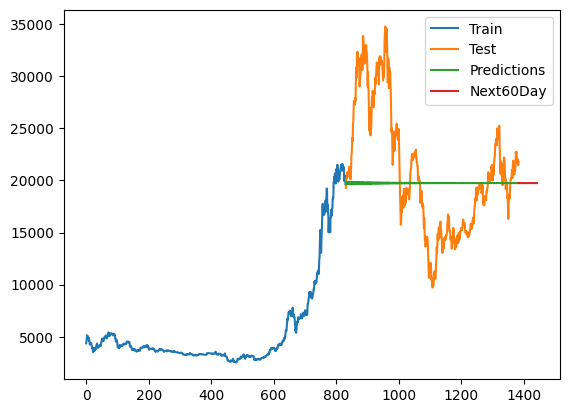

In [ ]:
#Show plot ratio 6:4
plt.plot(train_data64.index, train_data64['Close'])
plt.plot(test_data64.index, test_data64['Close'])
plt.plot(test_data64.index, y_pred64[:554])

plt.plot(last_data64,y_next_60_days64)
plt.legend(['Train', 'Test', 'Predictions','Next60Day'])
plt.show()
# Better